In [215]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
from ipywidgets import IntProgress
%matplotlib inline

## Logic Based FizzBuzz Function [Software 1.0]

In [216]:
def fizzbuzz(n):
    
    # Logic Explanation
    #ANSWER : 
    # First condition is testing if the number is divisible by 3 as well as by 5 and returns "FizzBuzz"
    # If the first condition is not satisfied then it checks if it is divisible by 3 and return "Fizz"
    # If both of the above tests are not satisfying, then it will check whether it is divisible by 5 and return "Buzz"
    # If all the conditions above do not saitify then it returns "Other"
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [217]:
def createInputCSV(start,end,filename):
    
    # Because list is indexed type of data structure and we can access the input from inputData and output from 
    # outputData using same index number.
    inputData   = []
    outputData  = []
    
    # Because when we create a ML model, we need to train it using the past known data where we already know the 
    # input variables(input) and output variables(labels) values'. When the model is trained appropriately, then 
    # it can be applied on unknown data where input variables are fed and it automatically calculates 
    # the value of output variable(s).
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Dataframe is like a 2-D tabular structure(mostly heterogenous) where coloums and rows are labled.
    # When dataframe is created from dictionary type of data structure then keys of the dictionary become the 
    # column names and the default index number become the row names. This resulting structure can easily be
    # exported into an excel sheet or csv.
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [218]:
def processData(dataset):
    
    # Because when the data is fed to the input layer then the 10 neural to be fed in the input layer. 
    # ,while the input contains only one decimal digit. 
    # To be able to feed the put layer the we are enocing the input into binary format
    # For output we are assigning 4 values depending upon the outcome from 0 to 3 as encoded below.
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [219]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        # Because we have the highest digit of 1000 which can be accomodated in the binary number of length 10.
        # Here the data is converted into binary format and reversed
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [220]:
# Encoding the 4 categories into the numbers which we will use in the output layer. Also called Labels. 
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [221]:
# Create datafiles
createInputCSV(101,1001,'training.csv')  # The training set starts from index 101 to 1000
createInputCSV(1,101,'testing.csv')      # The testing set starts from index 1 tp 100

training.csv Created!
testing.csv Created!


In [222]:
# Read Dataset
trainingData = pd.read_csv('training.csv')    # Read data from csv file and load it into the pandas dataframe
testingData  = pd.read_csv('testing.csv')     # Read data from csv file and load it into the pandas dataframe

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)   # Training data is processed
processedTestingData, processedTestingLabel   = processData(testingData)    # Testing data is processed

## Tensorflow Model Definition

In [223]:
# Defining Placeholder
# Placeholders are the type of variables nodes where data can be fed from outside when we actually run the model
inputTensor  = tf.placeholder(tf.float32, [None, 10])   #Placeholder for input data
outputTensor = tf.placeholder(tf.float32, [None, 4])    # Placeholder for output data

In [224]:
# The number of neurons which 1st hidden neurons will have i.e. 1000
NUM_HIDDEN_NEURONS_LAYER_1 = 1000          

# Learning rate, which will be later used to optimize for optmizer function
# Learning rate defines at what rate the optimizwer function will move towards minima per iteration
# Less than optimum learning rate will slow down the process where as higher learning rate will have chances of 
# skipping the minima all together. So it will never converge rather it will keep on going back and forth.
LEARNING_RATE = 0.05                     

# Initializing the weights to Normal Distribution
# The weights will keep on adjusting towards optimum values in each iteration. Conceptually, weights determine the 
# discrimination factor of a particular variable in the newural network. More the weight, more will be it's 
# contribution in determining the solution.
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
# We will need a total of 10(input layer number) * 100(number of hidden layers)
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])

# Initializing the hidden to output layer weights
# In this case we will need 100(number of hidden neurons layers) * 4(output neurons, we have only 4 categories)
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer
# Matrix multiplication is done and then rectifier neural network activation function is used 
# for regularization of the resulting multiplication
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))

# Computing values at the output layer
# Matrix multiplication of hidden layer and output weights it done. 
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
# Error function computes the difference between actual output and model output.
# Here we are calculating the error in the output as compared to the output label
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
# We are using Gradient Descent function to optimize the error or to reach the minima.
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

# Training the Model

In [225]:
NUM_OF_EPOCHS = 5000
BATCH_SIZE = 128

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    # We had only defined the model previously. To run the model, all the variables need to be initialized and run.
    # Actual computation can only start after the initialization.
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        #Shuffling is done to have even more randmized data, which adds to the generalization of model even more.
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        # With batch size of 128, there will be total of 900/128 runs in each epoch where 900 is the total 
        # training data.
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        # We are checking here the accuracy of model after each epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

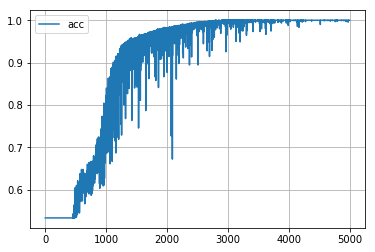

In [226]:
# Plot of accuracy of model after each epoch. Probability is on the y axis and epochs on the x-axis.
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [227]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

In [228]:
wrong   = 0
right   = 0

predictedTestLabelList = []

#Comparing the predicted value with the actual label in training data
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 2  Correct :98
Testing Accuracy: 98.0
